<h1 style="text-align:center"><u>Book Recommendation System</u></h1>

<h2>Introduction</h2>

The main purpose of this work is to learn <font color='orange'>**embeddings**</font>. Embeddings can be considered as a representation of a document in a space (called **embedding space**) where similar documents should be very close to each other. Therefore to guide our comprehension of what are embeddings, we will build a recommendation system based on books in wikipedia. The principle is as follow: "<u>*books with Wikipedia pages that link to similar Wikipedia pages are similar to each other*</u>". Ex: Book1 <-- link2; Book3 <-- link2 => Book1 and Book3 are similar. So, to exhibit this similarity, we will use neural network entity embeddings, mapping each book and each Wikipedia link (Wikilink) to a 50-number vector.

Embeddings have demonstrated some advantages in representing categorical variables: 
1. They help in reducing the original space where documents are expressed. In our case for example, if we were using *one-hot-encoding* method to representing books, we would have 3.7e+06 length vector for each book. 
2. They preserve similarity in terms of semantic meaning of each document (the books in our case) that is not the case of *one-hot-encoding* where semantic meaning of document is not preserved. By training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the books, we also get a representation that keeps similar books (in terms of what they talk about) closer to each other. Basic approach for a recommendation system is to find the closest books for any book in other to recommend to a user books that may have same content like those he/she already read. Thanks to [this notebook](1-Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb), we have access to every single book article on Wikipedia, which will let us create an effective recommendation system.

<h2>Approach</h2>

To create entity embeddings, we need to <u>build an **embedding neural network**</u> and train it <u>on a **supervised machine learning task**</u> that will <u>result in **similar books** (and similar links) having closer representations</u> in embedding space. <font color='orange'>The parameters of the neural network - the weights - are the embeddings</font>, and so during training, these numbers are adjusted to minimize the loss on the prediction problem. In other words, the network tries to accurately complete the task by changing the representations of the books and the links.

Once we have the embeddings for the books and the links, we can find the most similar book to a given book by computing the distance between the embedded vector for that book and all the other book embeddings. <u>We'll use the **cosine distance**</u> which measures the angle between two vectors as a measure of similarity (another valid option is the Euclidean distance). We can also do the same with the links, finding the most similar page to a given page. (I use links and wikilinks interchangeably in this notebook). The steps we will follow are:

1. Load in data and clean
2. Prepare data for supervised machine learning task
3. Build the entity embedding neural network
4. Train the neural network on prediction task
5. Extract embeddings and find most similar books and wikilinks
6. Visualize the embeddings using dimension reduction techniques

*Question*: But what consists the Supervised Machine Learning Task ? 🤔<br/>
*Answer*: Find the model that correctly <u>Maps Books to Links</u> 😀

For our machine learning task, we'll set up the problem as <u>identifying</u> <font color='green'>whether</font> <u>or</u> <font color='red'>not</font> <u>a particular link was present in a book article</u>. The training examples will consist of (book, link) pairs, with some pairs true examples - actually in the data - and others negative examples - do not occur in the data. It will be the network's job to adjust the entity embeddings (the neuralnets weights) of the books and the links in order to accurately make the classification. 

|                      Books                          | Links |  Link present/absent ?  |
|:---------------------------------------------------:|:---------:|:------:|
| Book4|   wikilink1   |  <font color='green'>Present</font>  |
| Book4|   wikilink7   |  <font color='red'>Absent<font>   |
| Book4|   wikilink8   |  <font color='green'>Present</font>  |
| Book2|   wikilink7   |  <font color='red'>Absent<font>   |
| Book2|   wikilink1   |  <font color='green'>Present</font>  |
| Book5|   wikilink3   |  <font color='red'>Absent<font>   |
| Book5|   wikilink5   |  <font color='red'>Absent<font>   |
| Book5|   wikilink1   |  <font color='green'>Present</font>  |
| Book1|   wikilink5   |  <font color='green'>Present</font>  |

<u>**Keep in mind**</u>: Although we are training our neuralnet for a supervised machine learning task, our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings, so we do not use a validation or testing set. We use the prediction problem as a means to an end rather than the final outcome.

<h2>Neural Network Embeddings for better representing large sequence of texts</h2>


Neural Network embeddings have proven to be very powerful concepts both for modeling language and for representing categorical variables.  For example, the [Word2Vec](https://www.tensorflow.org/tutorials/text/word2vec?hl=fr) word embeddings by Google, map a word to a vector based on training a neural network on millions of words. These embeddings can be used in any supervised model because they are just numerical representations of categorical variables. Much as we one-hot-encode categorical variables to use them in a random forest for a supervised task, we can also use entity embeddings to include categorical variables in a model. The embeddings are also useful because we can find entities that are close to one another in embedding space which might - as in a book recommendation system - allow us to find the most similar categories among tens of thousands of choices.

We can also use the Entity Embeddings to visualize words or categorical variables, such as creating a map of all books on Wikipedia. The entity embeddings typically are still high-dimensional - we'll use 50 numbers for each entity - so we need to use a dimension reduction technique such as [TSNE](https://distill.pub/2016/misread-tsne/) or [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) to visualize the embeddings in lower dimensions. (These are both manifold embedding methods so in effect we will embed the embeddings for visualization!) We'll take a look at doing this at the end of the notebook and later will upload the embeddings into a application custom-built for this purpose ([projector.tensorflow.org](https://projector.tensorflow.org/)). Entity embeddings are becoming more widespread thanks to the ease of development of neural networks in Keras and are a useful approach when we want to represent categorical variables with vectors that place similar categories close to one another. Other approaches for encoding categorical variables do not represent similar entities as being closer to one another, and entity embedding is a learning-based method for this important task.

Overall, this project is a great look at the potential for neural networks to create meaningful embeddings of high dimensional data and a practical application of deep learning. The code itself is relatively simple, and the Keras library makes developing deep learning models enjoyable!

The code here is adapted from the excellent [Deep Learning Cookbook](https://www.amazon.com/Deep-Learning-Cookbook-Practical-Recipes/dp/149199584X), the notebooks for which can be found on [this GitHub repository]((https://github.com/DOsinga/deep_learning_cookbook/tree/master)). Check out this book for practical applications of deep learning and great projects!

<h3>1. Load in data and clean</h3>

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the [Downloading and Parsing Wikipedia Data](1-Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb) Notebook.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import warnings
  

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

In [2]:
import json

books = []

with open('./data/found_books_filtered.ndjson', 'r') as file:
    # Append each line to the books
    books = [json.loads(row) for row in file]

# Remove non-book items
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]] # Articles
books = [book for book in books if 'Wikipedia:' not in book[0]] # Books
print(f'Found {len(books)} books.')

Found 37020 books.


In [3]:
books_with_wikipedia[0]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 {'name': 'Global Wikipedia',
  'author': 'Pnina Fichman and Noriko Hara',
  'country': 'United States',
  'language': 'English',
  'subject': 'Wikipedia',
  'publisher': 'Rowman  &  Littlefield',
  'release_date': '2014',
  'pages': '178',
  'isbn': '978-0810891012'},
 ['User:Adler.fa',
  'User:Maximilianklein',
  'User:Piotrus',
  'User:Kimaus',
  'User:Tbayer (WMF)',
  'Rowman  &  Littlefield',
  'Indiana University Bloomington',
  'User:Maximilianklein',
  'User talk:Maximilianklein',
  'File:Immanuel Kant (painted portrait).jpg',
  'Immanuel Kant',
  'PageRank',
  'CheiRank',
  'm:Research:Newsletter/2013/April#How_Wikipedia.27s_Google_matrix_differs_for_politicians_and_artists',
  'm:Research:Newsletter/2013/July#Multilingual_ranking_analysis:_Napoleon_and_Michael_Jackson_as_Wikipedia.27s_.22global_heroes.22',
  'DBpedia',
  'User:Piotrus',
  'OpenSym',
  'Chinese Wikipedia',
  'Baidu Baike',
  'microblog',
  'Twitter',


In [4]:
books[0]

['Freud: His Life and His Mind',
 {'1': '< !-- See Wikipedia:WikiProject_Books -- >',
  'name': 'Freud: His Life and His Mind',
  'image': 'File:Freud, His Life and His Mind (first edition).jpg',
  'caption': 'Cover of the first edition',
  'author': 'Helen Walker Puner',
  'country': 'United States',
  'language': 'English',
  'subject': 'Sigmund Freud',
  'publisher': 'Dell Publishing',
  'pub_date': '1947',
  'media_type': 'Print (Hardcover and Paperback)',
  'pages': '288 (1959 edition)',
  'isbn': '978-1560006114'},
 ['Sigmund Freud',
  'Dell Publishing',
  'Hardcover',
  'Paperback',
  'Sigmund Freud',
  'Erich Fromm',
  'Dell Publishing',
  'Anna Freud',
  'Ernest Jones',
  'Carl Jung',
  'Wilhelm Stekel',
  'Fritz Wittels',
  'Maurice English',
  'The Nation',
  'Frederick Crews',
  'The New York Review of Books',
  'Peter Gay',
  'Freud: A Life for Our Time',
  'The Life and Work of Sigmund Freud',
  'Louis Breger',
  'Wilhelm Fliess',
  'Freud family',
  'Cambridge University

There are a few articles that were caught which are clearly not books.

In [5]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

<img src="static\book_template.PNG" width=20% align ='center'>

Each legitimate book contains the title, the information from the `Infobox book` (image above) template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article (a rough estimate of the length of the article).

In [6]:
n = 21 # book N°21
print(f"*Title* : {books[n][0]}; \n\n *Infobox* : {books[n][1]};\n\n *Wikilinks* : {books[n][2][:5]}; \n\n *External links* : \
    {books[n][3][:5]};\n\n {books[n][3][:5]};\n\n *Date of last edit* : {books[n][4]};\n\n *Number of pages* : {books[n][5]}")

*Title* : Limonov (novel); 

 *Infobox* : {'name': 'Limonov', 'author': 'Emmanuel Carrère', 'translator': 'John Lambert', 'country': 'France', 'language': 'French', 'publisher': 'P.O.L.', 'pub_date': '2011', 'english_pub_date': '2014', 'pages': '488', 'isbn': '978-2-8180-1405-9'};

 *Wikilinks* : ['Emmanuel Carrère', 'biographical novel', 'Emmanuel Carrère', 'Eduard Limonov', 'Prix de la langue française']; 

 *External links* :     ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php', 'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html', 'http://limonow.de/carrere/index.html', 'http://www.tout-sur-limonov.fr/222318809'];

 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php', 'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html', 'http://limonow.de/carrere/index.html', 'http://www.to

> Book 21

May be you'll notice some difference between the caption and information above. Data we are using were scapped by 01/09/2018 and the caption were taken by 01/07/2023. So, things may have changed since then.</br></br>
<img src="./static/Limonov(novel).png" width=75% align ='center'>

**General note:** We will only use the wikilinks, which are saved as the third element (index 2) for each book.

<h3>2. Prepare data for supervised machine learning task</h3>

> Map books to integers

First we want to create a mapping of book titles to integers. When we feed books into the embedding neural network, we will have to represent them as numbers, and this mapping will let us keep track of the books. We'll also create the reverse mapping, from integers back to the title.

In [7]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

> Exploring Wikilinks

Although it's not our main focus, we can do a little exploration. Let's find the number of unique Wikilinks and the most common ones in the entire dataset. To create a single list from a list of lists, we can use the `itertools` chain method.

In [8]:
from itertools import chain

# Unique wikilinks
wikilinks = list(chain(*[book[2] for book in books])) # list(chain(*[['a', 'b'], ['c', 'a', 'e']])) => ['a', 'b', 'c', 'a', 'e']
print(f"There are {len(set(wikilinks))} unique wikilinks.")

# Wikilinks that appear in more than 2 books at least
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

There are 311276 unique wikilinks.
There are 17032 unique wikilinks to other books.


> EDA: Most Linked-to Articles

Let's take a look at which pages are most linked to by books on Wikipedia.

We'll make a utility function that takes in a list and returns a sorted ordered dictionary of the counts of the items in the list. The $collections$ module has a number of useful functions for dealing with groups of objects.

In [9]:
from collections import Counter, OrderedDict

def count_items(l:list):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

We only want to count wikilinks from each book once, so we first find the set of links for each book, then we flatten the list of lists to a single list, and finally pass it to the count_items function.

In [10]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

The most linked to pages are in fact not that surprising! One thing we should notice is that there are discrepancies in capitalization. We want to normalize across capitalization, so we'll lowercase all of the links and redo the counts.

In [11]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

$Conclusion:$ Normalizing wikilinks changes the rankings ! This illustrates an important point: always make sure to take a look at your data before modeling!😉

> Remove Most Popular Wikilinks

I'm going to remove the **most popular wikilinks** because these **are not very informative**. Knowing whether a book is 'hardcover' or 'paperback' is not that important to the content. We also don't need the two Wikipedia... (wikipedia:wikiproject books, wikipedia:wikiproject novels) links since these do not distinguish the books based on content. <br/>

-> Task 1: It is recommended to play around with the wikilinks that are removed because some might have a large effect on the recommendations.

(This step is similar to the idea of [TF-IDF (Term Frequency Inverse Document Frequency)](https://tfidf.com/). When dealing with words in documents, the words that appear most often across documents are usually not that helpful because they don't distinguish documents. TF-IDF is a way to weight a word higher for appearing more often within an article but decrease the weighting for a word appearing more often between articles.)

In [12]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

Since there are so many unique wikilinks, I'm going to limit the list to wikilinks mentioned 4 or more times. Hopefully this reduces the noise that might come from wikilinks that only appear a few times. Keeping every single link will increase the training time significantly, but experiment with this parameter if you are interested.

-> Task 2: Try different treshold for wikilinks appearance then analyse results obtained

In [13]:
# Limit to greater or equal than 4 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


$Conclusion$: By removing meaningless wikilinks (wikilinks that appear almost every time and those that do not link to minimum 4 books), we drastically reduce noises in our data. We have now 41758 unique wikilinks instead of 297624

> EDA: Most Linked-to Books

As a final bit of exploration, let's look at the books that are mentioned the most by other books on Wikipedia. We'll take the set of links for each book so that we don't have multiple counts for books that are linked to by another book more than once.

In [14]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

It's not surprising that several of these are references ("Encyclopedia...."). We also see that a few classics make it into the list ("The Wonderful Wizard of Oz", "Alice's Adventures in Wonderland")!

> Potential Additional Cleaning Step

Annother option to try more data cleaning would be to clean the link entities. For example, both `the new york times` and `new york times` are in the links. These could clearly be combined into a single entry because they link to the same exact page. This might require manual inspection of the links, and I decided not to do this because of the time involved! The final embeddings turned out well even without this step, but it might make sense to do in the future.

I'm not sure why the same link is represented as two different names (I extracted the title of the link to try and alleviate this issue), but it occurs many times, even for the same book!

In [15]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(f"-Title-- : {book[0]}\n-Wikilinks-- : {book[2]}")
        break

-Title-- : The Big Picture: Who Killed Hollywood? and Other Essays
-Wikilinks-- : ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [16]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

2742

996

-> Task3: Try some additionnal cleanning techniques (by inspecting some sample for example) in order to combine words as `The new york times` and `new york times` into single entry as those words refer to the same wikilink.

> Wikilinks to index

As with the books, we need to map the Wikilinks to integers. We'll also create the reverse mapping.

In [17]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


<h2>Supervised Machine Learning Task</h2>

In [18]:
import numpy as np
import pandas as pd

Now that we have clean data, we'll move on to the second step: developing a supervised machine learning task to train an embedding neural network. As a reminder, we'll state the problem as: given a book title and a link, identify if the link is in the book's article.

> Build a training set

In order for any machine learning model to learn, it needs a training set. We are going to treat this as a supervised learning problem: given a pair (book, link), we want the neural network to learn to predict whether this is a legitimate pair - present in the data - or not.

To create a training set, for each book, we'll iterate through the wikilinks on the book page and record the book title and each link as a tuple. The final pairs list will consist of tuples of every (book, link) pairing on all of Wikipedia.

In [19]:
import pickle

# pairs = []

# # Iterate through each book
# for book in books:
#     # Iterate through the links in the book
#     pairs.extend((book_index[book[0]], link_index[link.lower()]) \
#                 for link in book[2] if link.lower() in links)

# # Serialize
# fileObj = open('./data/pairs.obj', 'wb')
# pickle.dump(pairs,fileObj)
# fileObj.close()

# Deserialize
fileObj = open('./data/pairs.obj', 'rb')
pairs = pickle.load(fileObj)
fileObj.close()

len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

We now have over 770,000 <font color='green'>positive examples</font> on which to train! Each pair represents one Wikilink for one book. Let's look at a few examples.

Later on we'll create the <font color='red'>negative examples</font> by randomly sampling from the links and the books and making sure the resulting pair is not in pairs.

In [20]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]
index_book[pairs[900][0]], index_link[pairs[900][1]]

('Slaves in the Family', 'category:american biographies')

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

In [21]:
pairs_set = set(pairs)

Let's look at the (book, link) pairs that are represented most often in the data.

In [22]:
x = Counter(pairs)
sorted(x.items(), key=lambda x: x[1], reverse=True)[:5]

[((13337, 31111), 85),
 ((31899, 65), 77),
 ((25899, 8850), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [23]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'hydrophobie (song)')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

There's nothing wrong with books that link to the same page many times. They are just more likely to be trained on since there are more of them.

> **Important note** about Training/Testing Set !!!

As we said before, to compute the embeddings, we are not going to create a separate validation or testing set. While this is a **must** for a normal supervised machine learning task, in this case, our primary objective is not to make the most accurate model, but to generate the best embeddings. The prediction task is just the method through which we train our network to make the embeddings. At the end of training, we are not going to be testing our model on new data, so we don't need to evaluate the performance. Instead of testing on new data, we'll look at the embeddings themselves to see if books that we think are similar have embeddings that are close to each other.

If we kept a separate validation / testing set, then we would be limiting the amount of data that our network can use to train. This would result in less accurate embeddings. Normally with any supervised model, we need to be concerned about overfitting, but again, because we do not need our model to generalize to new data and our goal is the embeddings, we will make our model as effective as possible by using all the data for training. In general, always have a separate validation and testing set (or use cross validation) and make sure to regularize your model to prevent overfitting.

> Generator for training samples

We need to generate positive samples and negative samples to train the neural network. The positive samples are simple: pick a pair from `pairs` and assign it a 1. The negative samples are also fairly easy: pick one random link and one random book, make sure they are not in `pairs`, and assign them a -1 or a 0. (We'll use either a -1 or 0 for the negative labels depending on whether we want to make this a regression or a classification problem. Either approach is valid, and we'll try out both methods.)

The code below creates a generator that yields batches of samples each time it is called. Neural networks are trained incrementally - a batch at a time - which means that a generator is a useful function for returning examples on which to train. Using a generator alleviates the need to store all of the training data in memory which might be an issue if we were working with a larger dataset such as images.

In [24]:
import random
random.seed(100)

def generate_batch(pairs:tuple, n_positive:int = 50, negative_ratio = 1.0, classification:bool = False):
    """
    Generate batches of samples for training
    
    Params
    ------
    * pairs:
    * n_positive:
    * negative_ratio: 
    * classification: 
    
    Return
    -------
    A generator of batches. Should call `next` on this object to get a new batch
    """
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    pos_label = 1
    if classification:
        neg_label = 0
    else:
        neg_label = -1

# This creates a generator
    while True:
        # randomly choose n_positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(population=pairs, k=n_positive+1)):
            batch[idx, :] = (book_id, link_id, pos_label) 

        # Increment idx by 1
        idx += 1 # Negatives examples index start from n_positive +1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book_id = random.randrange(len(books))
            random_link_id = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book_id, random_link_id) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book_id, random_link_id, neg_label)
                idx += 1
        # Make sure to shuffle order to avoid pattern in batch
        # otherwise the neuralnets will make this assumption: (n_positive example are followed by negatives examples)
        np.random.shuffle(batch)
        
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [25]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}') 

Book: The Ancestor's Tale            Link: evolution                                Label: 1.0
Book: The Early Fears                Link: category:11th-century history books      Label: -1.0
Book: Ferdydurke                     Link: 1937 in literature                       Label: 1.0
Book: Sunrise (Hunter novel)         Link: category:novels set in the 13th century  Label: -1.0
Book: This Boy's Life                Link: twelver                                  Label: -1.0
Book: Trouble with Lichen            Link: jane leslie conly                        Label: 1.0


~~**Note** : If you run several times the previous cell, you'll notice the equillibrium of classes. This is a point to draw attention when training a supervised machine learning model. In a perfect world, classes should at best be balanced, at worst the imbalance shouldn't be so great, as most models have this ability to adapt to slightly unbalanced data. When classes are unbalanced, things may be little complicated. Here, since we're building our training set ourselves, we try to build balanced sets.~~

-> Task4: Try to build unbalanced dataset by changing n_positive and negative_ratio and observe what happenning.

$Conclusion$: The neural network will take in the book index and the link index and try to embed them in such a way that it can predict the label from the embeddings.

<h3>3. Build the entity embedding neural network</h3>

With our dataset and a supervised machine learning task, we're almost there. The next step is the most technically complicated but thankfully fairly simple with Keras. We are going to construct the neural network that learns the entity embeddings. The input to this network is the (book, link) (either positive or negative) as integers, and the output will be a prediction of whether or not the link was present in the book article. However, we're not actually interested in the prediction except as the device used to train the network by comparison to the label. What we are after is at the heart of the network: the embedding layers, one for the book and one for the link each of which maps the input entity to a 50 dimensional vector. The layers of our network are as follows:

1. Input: parallel inputs for the book and link
2. Embedding: parallel embeddings for the book and link
3. Dot: computes the dot product between the embeddings to merge them together
4. Reshape: utility layer needed to correct the shape of the dot product
5. [Optional] Dense: fully connected layer with sigmoid activation to generate output for classification

After converting the inputs to an embedding, we need a way to combine the embeddings into a single number. For this we can use the dot product which does element-wise multiplication of numbers in the vectors and then sums the result to a single number. This raw number (after reshaping) is then the ouput of the model for the case of regression. In regression, our labels are either -1 or 1, and so the model loss function will be mean squared error in order to minimize the distance between the prediction and the output. Using the dot product with normalization means that the `Dot` layer is finding the cosine similarity between the embedding for the book and the link. Using this method for combining the embeddings means we are trying to make the network learn similar embeddings for books that link to similar pages.

> Classification vs Regression

For classification, we add an extra fully connected Dense layer with a sigmoid activation to squash the outputs between 0 and 1 because the labels are either 0 or 1. The loss function for classification is binary_crossentropy which measures the [error of the neural network predictions in a binary classification problem](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), and is a measure of the similarity between two distributions. We can train with either classification or regression, and in practice, I found that both approaches produced similar embeddings. I'm not sure about the technical merits of these methods, and I'd be interested to hear if one is better than the other.

The optimizer - the algorithm used to update the parameters (also called weights) of the neural network after calculating the gradients through backpropagation - is Adam in both cases ([Adam is a modification to Stochastic Gradient Descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). We use the default parameters for this optimizer. The nice thing about modern neural network frameworks is we don't have to worry about backpropagation or updating the model parameters because that is done for us. It's nice to have an idea of what is occuring behind the scenes, but it's not entirely necessary to use a neural network effectively.

In [26]:
#import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model, load_model

In [27]:
def book_embedding_model(embedding_size=10, classification=False):
    """
    Model to embed books and wikilinks using the functional API.
    train to discern if a link is present in an article.
    
    """
    
    # Both inputs are 1-D
    book = Input(name='book', shape=(1,))
    link = Input(name='link', shape=(1,))
    
    # Embedding the book (shape will be (None, 1, 50)) 
    # `None` is for the batch dimension
    book_embedding = Embedding(name='book_embedding',
                               input_dim=len(book_index), # Remember len(book_index)=37020
                               output_dim=embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name='link_embedding',
                               input_dim=len(link_index), # Remember len(link_index)=41758
                               output_dim= embedding_size)(link)
    
    # Merge the layers with a dot product along the third axis (shape will be (None, 1, 1))
    merged = Dot(name='dot_product', normalize=True, 
                 axes=2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape=(1,))(merged)
    
    if classification:
        merged = Dense(1, activation='sigmoid')(merged) # Extra layer if `classification`
        model = Model(inputs=[book, link], outputs=merged)
        model.compile(optimizer='Adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
    else:
        model = Model(inputs=[book, link], outputs=merged)
        model.compile(optimizer='Adam',
                      loss='mse',
                      metrics=['accuracy'])
    return model
    
    
# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 book (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 link (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 book_embedding (Embedding)     (None, 1, 10)        370200      ['book[0][0]']                   
                                                                                                  
 link_embedding (Embedding)     (None, 1, 10)        417580      ['link[0][0]']                   
                                                                                              

There are nearly 4.0 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data.

<h3>4. Train the neural network on prediction task</h3>

We have the training data - in a generator - and a model. The next step is to train the model to learn the entity embeddings. During this process, the model will update the embeddings (change the model parameters) to accomplish the task of predicting whether a certain link is on a book page or not. The resulting embeddings can then be used as a representation of books and links.

There are a few parameters to adjust for training. The batch size should generally be as large as possible given the memory constraints of the machine you are working with. The `negative_ratio` can be adjusted based on results. The number of `steps_per_epoch` is chosen such that the model sees a number of examples equal to the number of pairs on each epoch. This is repeated for 15 epochs (which might be more than necessary).

In [28]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 1)

# Train
history = model.fit(x=gen, epochs = 10, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 1)

Epoch 1/10
754/754 [==============================] - 21s 25ms/step - loss: 0.9950 - accuracy: 0.0616
Epoch 2/10
754/754 [==============================] - 18s 24ms/step - loss: 0.8274 - accuracy: 0.1453
Epoch 3/10
754/754 [==============================] - 18s 24ms/step - loss: 0.6678 - accuracy: 0.2159
Epoch 4/10
754/754 [==============================] - 18s 23ms/step - loss: 0.5523 - accuracy: 0.2415
Epoch 5/10
754/754 [==============================] - 18s 23ms/step - loss: 0.5036 - accuracy: 0.2510
Epoch 6/10
754/754 [==============================] - 18s 24ms/step - loss: 0.4803 - accuracy: 0.2584
Epoch 7/10
754/754 [==============================] - 17s 23ms/step - loss: 0.4669 - accuracy: 0.2645
Epoch 8/10
754/754 [==============================] - 18s 23ms/step - loss: 0.4592 - accuracy: 0.2683
Epoch 9/10
754/754 [==============================] - 18s 24ms/step - loss: 0.4523 - accuracy: 0.2719
Epoch 10/10
754/754 [==============================] - 18s 24ms/step - loss: 0.447

The loss decreases as training progresses which should give us confidence the model is learning something!

The entire trained model can be saved and later loaded in so you don't have to repeat the training. It's also possible to save certain layers.

In [29]:
model.save('./models/first_attempt.h5')

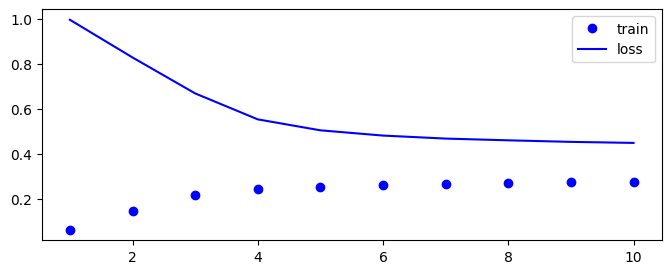

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='train')
plt.plot(epochs, loss, 'b', label='loss')
plt.legend()

plt.show();

The loss curve show how the loss during training is being reducing considerably until the 6-th epoch where it started to be approximately constant. In the orther hand the train curve accuracy is increasing until the 6-th epoch. As our goal is not to train a model that perform well on whichever prediction task, we'll not struggle to fine tune the previous model.

<h3>5. Extract embeddings and find most similar books and wikilinks</h3>

The trained model has learned - hopefully😄- representations of books and wikilinks that place similar entities next to one another in the embedding space. To find out if this is the case, we extract the embeddings and use them to find similar books and links.

In [31]:
model = load_model('./models/first_attempt.h5')

In [32]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape # Each index represents each book

(37020, 10)

Each book is now represented as a 50-dimensional vector.

We need to normalize the embeddings so that the dot product between two embeddings becomes the **cosine similarity**.

In [33]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1)) # W/|W|
book_weights[8564][:10]

np.sum(np.square(book_weights[0]))==1.0

array([-0.09250771,  0.09336135,  0.56108326, -0.25403342, -0.08792323,
        0.05302162,  0.50230277,  0.11940982, -0.38521096,  0.42176107],
      dtype=float32)

True

> Find similar books

We've trained the model and extracted the embeddings - great - but where is the book recommendation system? Now that we have the embeddings, we can use them to recommend books that our model has learned are most similar to a given book.

The function below takes in either a book or a link, a set of embeddings, and returns the `n` most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the [cosine similarity](https://nlp.stanford.edu/IR-book/html/htmledition/dot-products-1.html) between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [44]:
def compute_similarity(name, weights, index_name='book', n=10, 
                      least=False, return_dist=False, plot=False):
    """
    Find `n` most similar items (or least) to `name` based embeddings
    
    Params
    ------
    * name
    """
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
        
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between an item (book or link) and all others
        dists = np.dot(weights, weights[index[name]]) # (input_dim, embedding_dim) x (embedding_dim, 1)
    except KeyError:
        print(f'{name} not found')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n//2)] # Those `dists`<0
        closest = sorted_dists[-n-1 : len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closest distances
        distances = [dists[idx] for idx in furthest]
        distances.extend(dists[idx] for idx in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (6, 4),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s most and least similar to :'
        for word in name.split():
            # Title uses latex for italize
            name_str += " $\it{" + word + "}$"
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
    
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

One way to verify if the above function is working fine, we should have the most similar book to a book is that book itself. Because we multiply the item vector times all the other embeddings, the most similar should be the item itself with a similarity of 1.0.

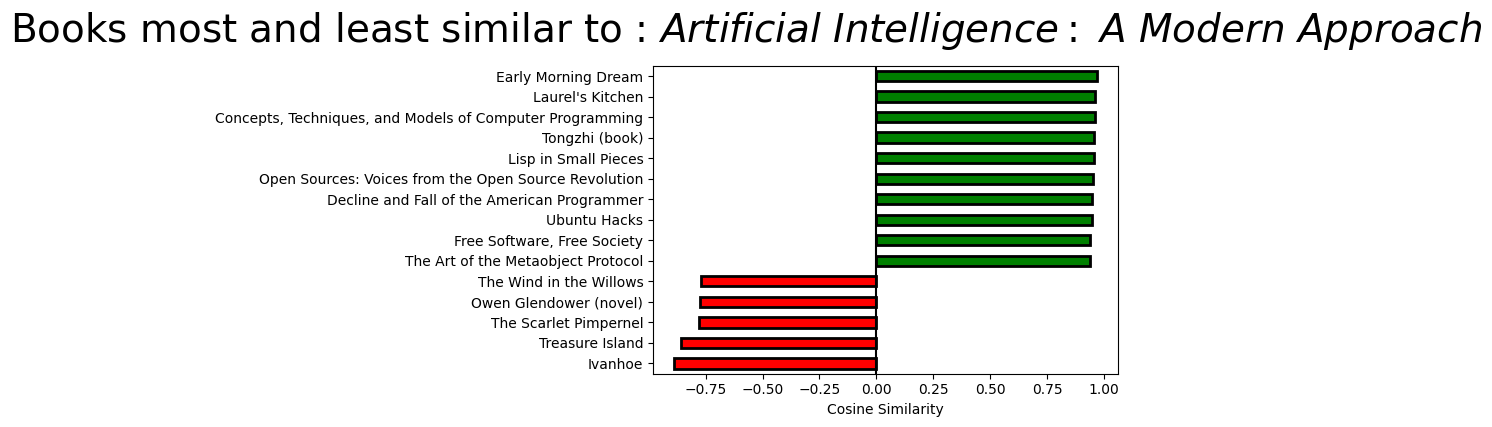

In [45]:
compute_similarity(name='Artificial Intelligence: A Modern Approach', weights=book_weights, n=10, plot=True)

$Conclusion$: Not bad by the looks of the results! **We have successfully built a book recommendation system using neural network embeddings.**

6. Visualize the embeddings using dimension reduction techniques

[Markdown styles](https://towardsdatascience.com/enrich-your-jupyter-notebook-with-these-tips-55c8ead25255)

[Hydra overview](https://towardsdatascience.com/stop-hard-coding-in-a-data-science-project-use-config-files-instead-479ac8ffc76f)

<u>credits</u>: [Will Koehrsen](https://medium.com/p/4d028e6f0526)